# Monte Carlo Simulation for Value at Risk (VaR) and Expected Shortfall (ES)

"""
In this notebook, we extend our risk analysis by estimating Value at Risk (VaR) 
and Expected Shortfall (ES) using Monte Carlo simulation.

Unlike the parametric and historical methods, the Monte Carlo approach allows us 
to model potential future returns by generating thousands of random price paths 
based on statistical properties of the historical data. 

We’ll simulate returns, compute the 95% VaR and ES, and visualize the results.
"""


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Improve visualization style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("muted")

# Display settings
pd.set_option('display.float_format', lambda x: '%.6f' % x)


# Value at Risk (VaR) and Expected Shortfall (CVaR) Analysis

In this notebook, we will extend the previous work on Value at Risk (VaR) by introducing the **Expected Shortfall (CVaR)**, also known as Conditional VaR.
This risk measure captures the *expected loss* beyond the VaR threshold — providing a deeper understanding of tail risk.


In [4]:
# Download historical data for the S&P 500 Index (^GSPC)
ticker = "^GSPC"
data = yf.download(ticker, start="2015-01-01", end="2025-01-01")

# Use the 'Close' column (already adjusted automatically)
prices = data["Close"]
returns = prices.pct_change().dropna()

returns.head()


/var/folders/40/qq7n2_gd71l5n9hlkzt509b00000gn/T/ipykernel_16920/1029264028.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Ticker,^GSPC
Date,
2015-01-05,-0.018278
2015-01-06,-0.008893
2015-01-07,0.011630
2015-01-08,0.017888
2015-01-09,-0.008404


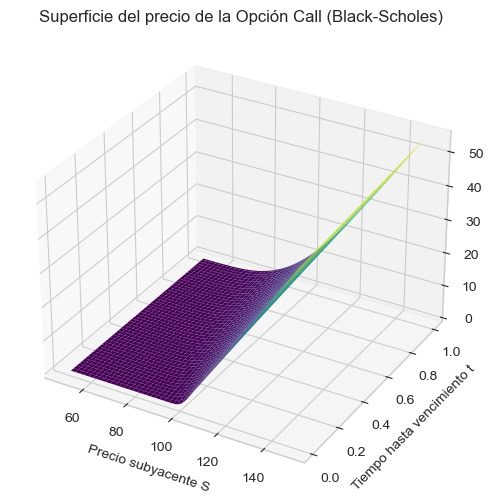

In [9]:
# Celda 4: Superficie 3D del precio del Call en función de S y t (autónoma)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

# Parámetros base (puedes modificarlos)
K = 100      # Strike
r = 0.05     # Tasa libre de riesgo
sigma = 0.2  # Volatilidad
T = 1.0      # Tiempo hasta vencimiento (1 año)

# Función Black-Scholes para Call
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

# Rango de valores
S = np.linspace(50, 150, 100)
t = np.linspace(0.01, T, 100)
S, t = np.meshgrid(S, t)

# Precio del call
C = black_scholes_call(S, K, t, r, sigma)

# Gráfica 3D
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S, t, C, cmap='viridis')
ax.set_title('Superficie del precio de la Opción Call (Black-Scholes)')
ax.set_xlabel('Precio subyacente S')
ax.set_ylabel('Tiempo hasta vencimiento t')
ax.set_zlabel('Precio del Call')
plt.show()


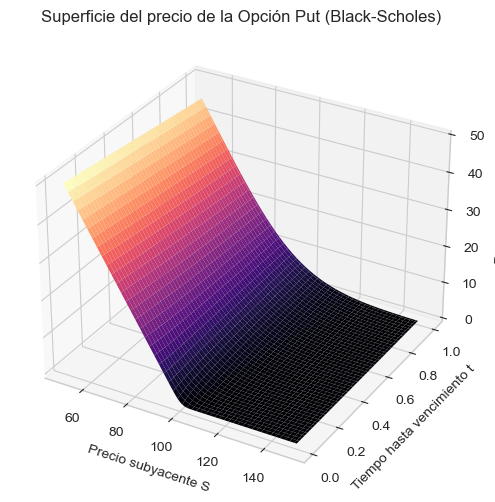

In [10]:
# Celda 5: Superficie 3D del precio del Put (Black-Scholes)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

# Parámetros base (mismos que antes)
K = 100
r = 0.05
sigma = 0.2
T = 1.0

# Función Black-Scholes para Put
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Rango de valores
S = np.linspace(50, 150, 100)
t = np.linspace(0.01, T, 100)
S, t = np.meshgrid(S, t)

# Precio del put
P = black_scholes_put(S, K, t, r, sigma)

# Gráfica 3D
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S, t, P, cmap='magma')
ax.set_title('Superficie del precio de la Opción Put (Black-Scholes)')
ax.set_xlabel('Precio subyacente S')
ax.set_ylabel('Tiempo hasta vencimiento t')
ax.set_zlabel('Precio del Put')
plt.show()


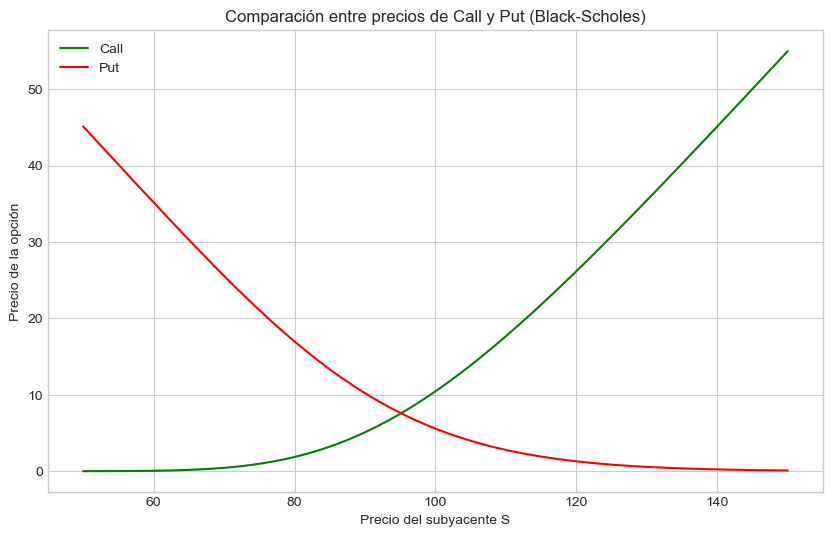

In [11]:
# Celda 6: Comparación del precio del Call y Put para distintos precios subyacentes

S = np.linspace(50, 150, 200)
T = 1.0

# Funciones reutilizadas
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Cálculos
call_prices = black_scholes_call(S, K, T, r, sigma)
put_prices = black_scholes_put(S, K, T, r, sigma)

# Gráfico
plt.figure(figsize=(10,6))
plt.plot(S, call_prices, label='Call', color='green')
plt.plot(S, put_prices, label='Put', color='red')
plt.title("Comparación entre precios de Call y Put (Black-Scholes)")
plt.xlabel("Precio del subyacente S")
plt.ylabel("Precio de la opción")
plt.legend()
plt.grid(True)
plt.show()


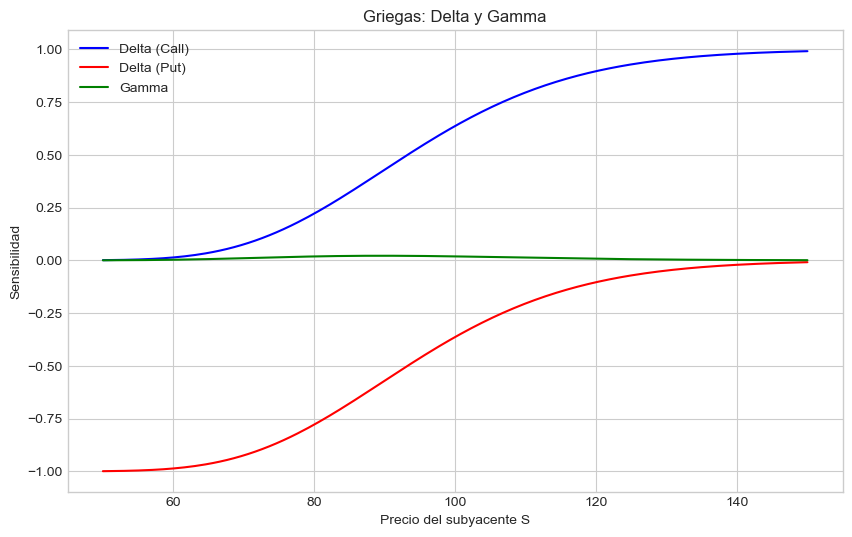

In [12]:
# Celda 7: Cálculo y visualización de las Griegas

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

K = 100
r = 0.05
sigma = 0.2
T = 1.0

S = np.linspace(50, 150, 200)

# Funciones para Griegas
def d1(S, K, T, r, sigma):
    return (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d2(S, K, T, r, sigma):
    return d1(S, K, T, r, sigma) - sigma*np.sqrt(T)

def delta_call(S, K, T, r, sigma):
    return norm.cdf(d1(S, K, T, r, sigma))

def delta_put(S, K, T, r, sigma):
    return norm.cdf(d1(S, K, T, r, sigma)) - 1

def gamma(S, K, T, r, sigma):
    return norm.pdf(d1(S, K, T, r, sigma)) / (S*sigma*np.sqrt(T))

def vega(S, K, T, r, sigma):
    return S * norm.pdf(d1(S, K, T, r, sigma)) * np.sqrt(T)

def theta_call(S, K, T, r, sigma):
    d1v = d1(S, K, T, r, sigma)
    d2v = d2(S, K, T, r, sigma)
    term1 = - (S * norm.pdf(d1v) * sigma) / (2 * np.sqrt(T))
    term2 = - r * K * np.exp(-r*T) * norm.cdf(d2v)
    return term1 + term2

def theta_put(S, K, T, r, sigma):
    d1v = d1(S, K, T, r, sigma)
    d2v = d2(S, K, T, r, sigma)
    term1 = - (S * norm.pdf(d1v) * sigma) / (2 * np.sqrt(T))
    term2 = r * K * np.exp(-r*T) * norm.cdf(-d2v)
    return term1 + term2

def rho_call(S, K, T, r, sigma):
    return K*T*np.exp(-r*T)*norm.cdf(d2(S, K, T, r, sigma))

def rho_put(S, K, T, r, sigma):
    return -K*T*np.exp(-r*T)*norm.cdf(-d2(S, K, T, r, sigma))

# Cálculos
deltaC = delta_call(S, K, T, r, sigma)
deltaP = delta_put(S, K, T, r, sigma)
gammaV = gamma(S, K, T, r, sigma)
vegaV = vega(S, K, T, r, sigma)
thetaC = theta_call(S, K, T, r, sigma)
thetaP = theta_put(S, K, T, r, sigma)
rhoC = rho_call(S, K, T, r, sigma)
rhoP = rho_put(S, K, T, r, sigma)

# Plot (Delta y Gamma como ejemplo)
plt.figure(figsize=(10,6))
plt.plot(S, deltaC, label='Delta (Call)', color='blue')
plt.plot(S, deltaP, label='Delta (Put)', color='red')
plt.plot(S, gammaV, label='Gamma', color='green')
plt.title("Griegas: Delta y Gamma")
plt.xlabel("Precio del subyacente S")
plt.ylabel("Sensibilidad")
plt.legend()
plt.grid(True)
plt.show()


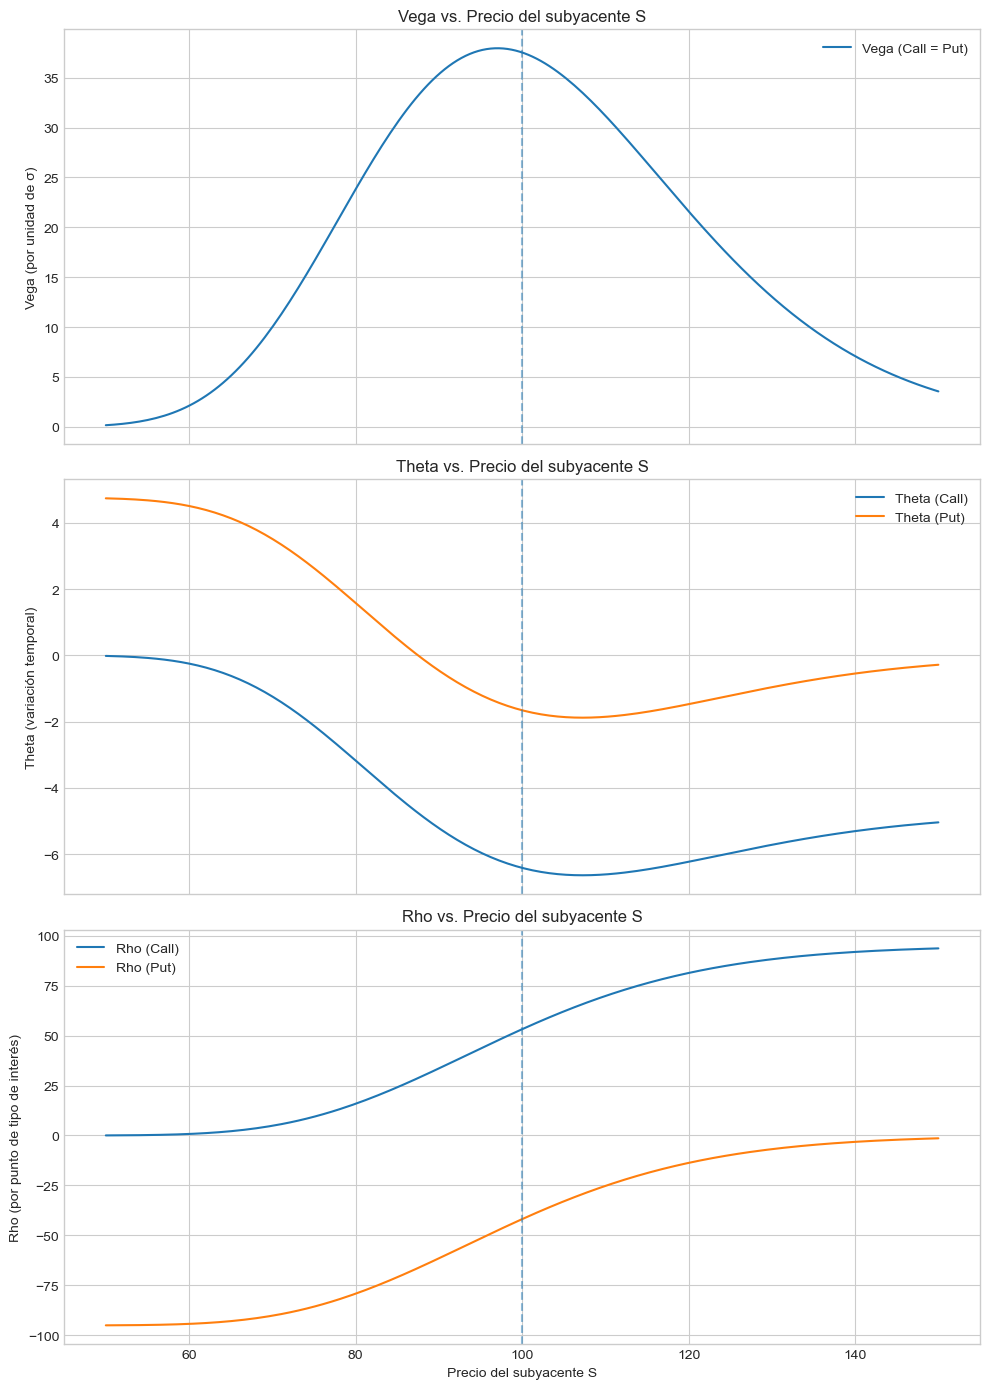

In [3]:
# ============================================================
# Celda 8 — Visualización de Vega, Theta y Rho (independiente)
# ============================================================

# --- Imports y configuraciones ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.style.use("seaborn-v0_8-whitegrid")

# --- Parámetros base ---
K = 100
r = 0.05
sigma = 0.2
T = 1.0
S = np.linspace(50, 150, 200)

# --- Funciones auxiliares ---
def d1(S, K, T, r, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

def d2(S, K, T, r, sigma):
    return d1(S, K, T, r, sigma) - sigma * np.sqrt(T)

def vega(S, K, T, r, sigma):
    """Sensibilidad al cambio en volatilidad σ (igual para Call y Put)."""
    return S * norm.pdf(d1(S, K, T, r, sigma)) * np.sqrt(T)

def theta_call(S, K, T, r, sigma):
    """Sensibilidad temporal del precio de Call."""
    d1v = d1(S, K, T, r, sigma)
    d2v = d2(S, K, T, r, sigma)
    term1 = - (S * norm.pdf(d1v) * sigma) / (2 * np.sqrt(T))
    term2 = - r * K * np.exp(-r * T) * norm.cdf(d2v)
    return term1 + term2

def theta_put(S, K, T, r, sigma):
    """Sensibilidad temporal del precio de Put."""
    d1v = d1(S, K, T, r, sigma)
    d2v = d2(S, K, T, r, sigma)
    term1 = - (S * norm.pdf(d1v) * sigma) / (2 * np.sqrt(T))
    term2 = r * K * np.exp(-r * T) * norm.cdf(-d2v)
    return term1 + term2

def rho_call(S, K, T, r, sigma):
    """Sensibilidad del precio de Call respecto al tipo de interés."""
    return K * T * np.exp(-r * T) * norm.cdf(d2(S, K, T, r, sigma))

def rho_put(S, K, T, r, sigma):
    """Sensibilidad del precio de Put respecto al tipo de interés."""
    return -K * T * np.exp(-r * T) * norm.cdf(-d2(S, K, T, r, sigma))

# --- Cálculos ---
vega_vals   = vega(S, K, T, r, sigma)
thetaC_vals = theta_call(S, K, T, r, sigma)
thetaP_vals = theta_put(S, K, T, r, sigma)
rhoC_vals   = rho_call(S, K, T, r, sigma)
rhoP_vals   = rho_put(S, K, T, r, sigma)

# --- Gráficos ---
fig, ax = plt.subplots(3, 1, figsize=(10, 14), sharex=True)

# 1️⃣ Vega
ax[0].plot(S, vega_vals, label='Vega (Call = Put)')
ax[0].axvline(K, linestyle='--', alpha=0.5)
ax[0].set_title('Vega vs. Precio del subyacente S')
ax[0].set_ylabel('Vega (por unidad de σ)')
ax[0].legend()
ax[0].grid(True)

# 2️⃣ Theta
ax[1].plot(S, thetaC_vals, label='Theta (Call)')
ax[1].plot(S, thetaP_vals, label='Theta (Put)')
ax[1].axvline(K, linestyle='--', alpha=0.5)
ax[1].set_title('Theta vs. Precio del subyacente S')
ax[1].set_ylabel('Theta (variación temporal)')
ax[1].legend()
ax[1].grid(True)

# 3️⃣ Rho
ax[2].plot(S, rhoC_vals, label='Rho (Call)')
ax[2].plot(S, rhoP_vals, label='Rho (Put)')
ax[2].axvline(K, linestyle='--', alpha=0.5)
ax[2].set_title('Rho vs. Precio del subyacente S')
ax[2].set_xlabel('Precio del subyacente S')
ax[2].set_ylabel('Rho (por punto de tipo de interés)')
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()


## Interpretación de Vega, Theta y Rho

**Vega**  
- Sensibilidad del precio a cambios en la volatilidad (σ).  
- En Black–Scholes, Vega de Call y Put es **igual**.  
- Máxima cuando **S ≈ K** (ATM) y disminuye al ir ITM/OTM.  
- Si σ sube 1 p.p., el precio cambia ≈ `Vega × 0.01`.

**Theta**  
- Mide la “pérdida de valor por paso del tiempo” (time decay).  
- Suele ser **negativa** para Calls y para Puts europeas (más acusada cerca del vencimiento y ATM).  
- Convención: en BSM está en **años**; para “por día”, divide entre 365.

**Rho**  
- Sensibilidad al tipo libre de riesgo (r).  
- **Call:** Rho **positiva** (sube r ⇒ sube la Call).  
- **Put:** Rho **negativa**.  
- Efecto mayor cuanto más grande es **T**.


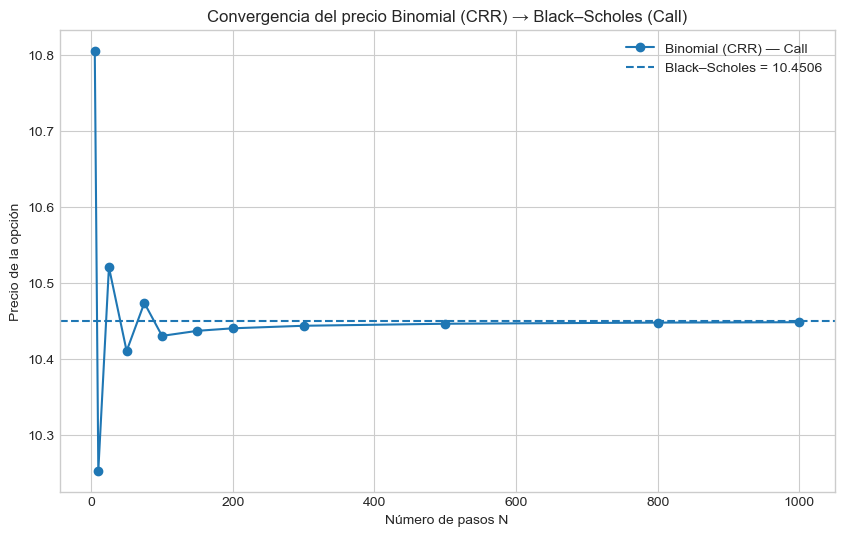

In [4]:
# ============================================================
# Celda 10 — Convergencia CRR → Black–Scholes (CALL) (independiente)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.style.use("seaborn-v0_8-whitegrid")

# --- Black–Scholes (Call) ---
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

# --- Binomial CRR (europea) ---
def price_binomial_crr(S0, K, T, r, sigma, N=100, option_type='call'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    disc = np.exp(-r * dt)
    p = (np.exp(r * dt) - d) / (u - d)
    if p < 0 or p > 1:
        raise ValueError("Prob. riesgo-neutral fuera de [0,1]. Ajusta N o parámetros.")
    # terminales S_T
    j = np.arange(N + 1)
    ST = S0 * (u**j) * (d**(N - j))
    if option_type == 'call':
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)
    # backward induction
    for _ in range(N):
        payoff = disc * (p * payoff[1:] + (1 - p) * payoff[:-1])
    return payoff[0]

# --- Parámetros de prueba ---
S0 = 100.0
K_  = 100.0
T_  = 1.0
r_  = 0.05
sigma_ = 0.2

# Referencia Black–Scholes
bs_call_ref = black_scholes_call(S0, K_, T_, r_, sigma_)

# Barrido de N
Ns = [5, 10, 25, 50, 75, 100, 150, 200, 300, 500, 800, 1000]
binom_prices = [price_binomial_crr(S0, K_, T_, r_, sigma_, N, 'call') for N in Ns]

# --- Gráfico ---
plt.figure(figsize=(10,6))
plt.plot(Ns, binom_prices, marker='o', label='Binomial (CRR) — Call')
plt.axhline(bs_call_ref, linestyle='--', label=f'Black–Scholes = {bs_call_ref:.4f}')
plt.title('Convergencia del precio Binomial (CRR) → Black–Scholes (Call)')
plt.xlabel('Número de pasos N')
plt.ylabel('Precio de la opción')
plt.legend()
plt.grid(True)
plt.show()


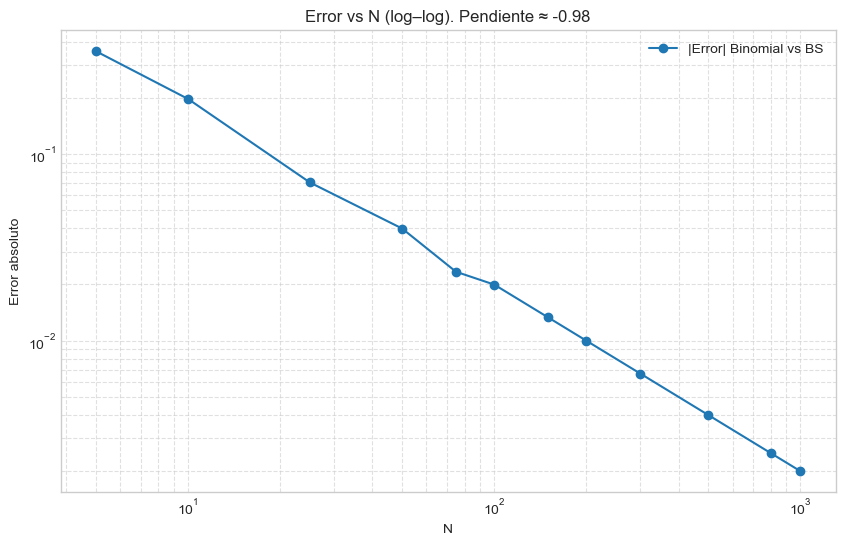

Pendiente estimada (log–log): -0.980
≈ -0.5 sugiere la convergencia típica O(N^{-1/2}) del esquema CRR para europeas.


In [5]:
# ============================================================
# Celda 11 — Error vs N en log–log y pendiente (independiente)
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.style.use("seaborn-v0_8-whitegrid")

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def price_binomial_crr(S0, K, T, r, sigma, N=100, option_type='call'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    disc = np.exp(-r * dt)
    p = (np.exp(r * dt) - d) / (u - d)
    if p < 0 or p > 1:
        raise ValueError("Prob. riesgo-neutral fuera de [0,1]. Ajusta N o parámetros.")
    j = np.arange(N + 1)
    ST = S0 * (u**j) * (d**(N - j))
    if option_type == 'call':
        payoff = np.maximum(ST - K, 0.0)
    else:
        payoff = np.maximum(K - ST, 0.0)
    for _ in range(N):
        payoff = disc * (p * payoff[1:] + (1 - p) * payoff[:-1])
    return payoff[0]

# Parámetros y datos
S0, K_, T_, r_, sigma_ = 100.0, 100.0, 1.0, 0.05, 0.2
bs_call_ref = black_scholes_call(S0, K_, T_, r_, sigma_)
Ns = np.array([5, 10, 25, 50, 75, 100, 150, 200, 300, 500, 800, 1000], dtype=int)
binom_prices = np.array([price_binomial_crr(S0, K_, T_, r_, sigma_, N, 'call') for N in Ns])

errors = np.abs(binom_prices - bs_call_ref)

# Para evitar log(0) si el error es extremadamente pequeño
mask = errors > 0
logN = np.log(Ns[mask].astype(float))
logE = np.log(errors[mask])
slope, intercept = np.polyfit(logN, logE, 1)

plt.figure(figsize=(10,6))
plt.loglog(Ns[mask], errors[mask], marker='o', label='|Error| Binomial vs BS')
plt.title(f'Error vs N (log–log). Pendiente ≈ {slope:.2f}')
plt.xlabel('N')
plt.ylabel('Error absoluto')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend()
plt.show()

print(f"Pendiente estimada (log–log): {slope:.3f}")
print("≈ -0.5 sugiere la convergencia típica O(N^{-1/2}) del esquema CRR para europeas.")


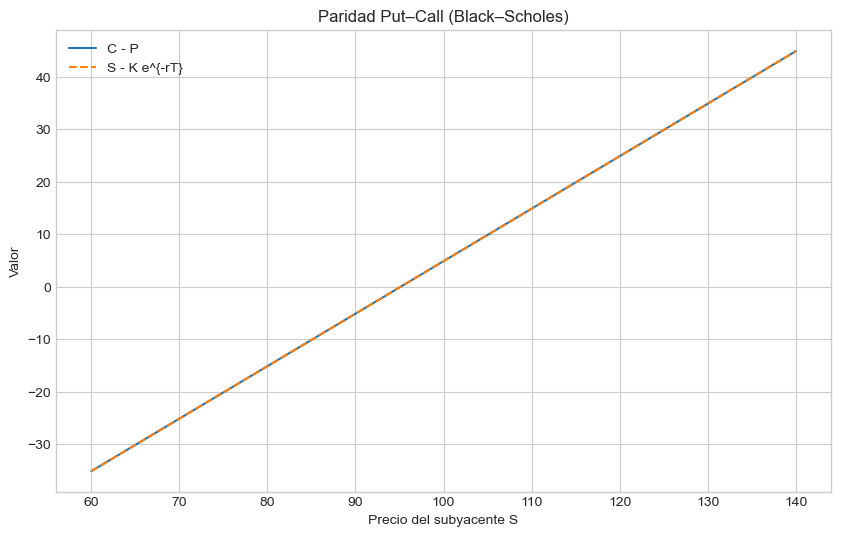

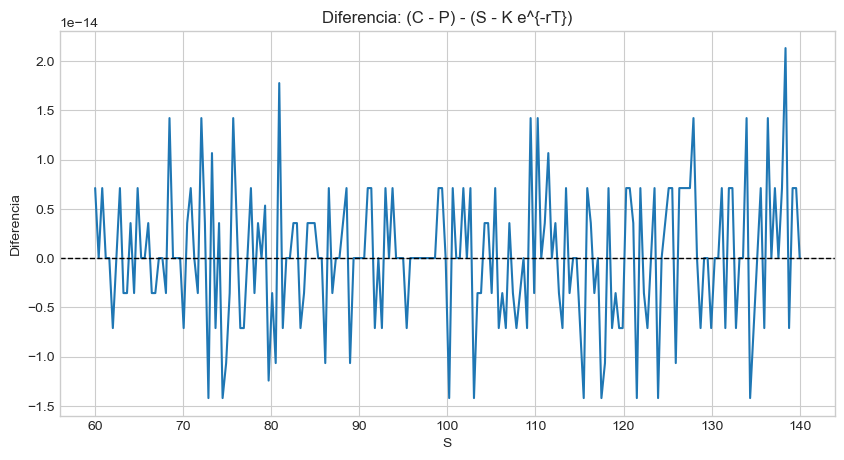

Máximo error numérico en la malla: 2.132e-14 (≈ 0 por redondeos)


In [6]:
# ============================================================
# Celda 12 — Paridad Put–Call: C - P ?= S - K e^{-rT}
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.style.use("seaborn-v0_8-whitegrid")

def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def bs_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# Parámetros
K = 100; r = 0.05; sigma = 0.2; T = 1.0
S = np.linspace(60, 140, 200)

C = bs_call(S, K, T, r, sigma)
P = bs_put(S, K, T, r, sigma)
paridad = C - P
rhs = S - K*np.exp(-r*T)
diferencia = paridad - rhs

plt.figure(figsize=(10,6))
plt.plot(S, paridad, label='C - P')
plt.plot(S, rhs, linestyle='--', label='S - K e^{-rT}')
plt.title('Paridad Put–Call (Black–Scholes)')
plt.xlabel('Precio del subyacente S')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(S, diferencia)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title('Diferencia: (C - P) - (S - K e^{-rT})')
plt.xlabel('S'); plt.ylabel('Diferencia')
plt.grid(True)
plt.show()

max_err = np.max(np.abs(diferencia))
print(f"Máximo error numérico en la malla: {max_err:.3e} (≈ 0 por redondeos)")


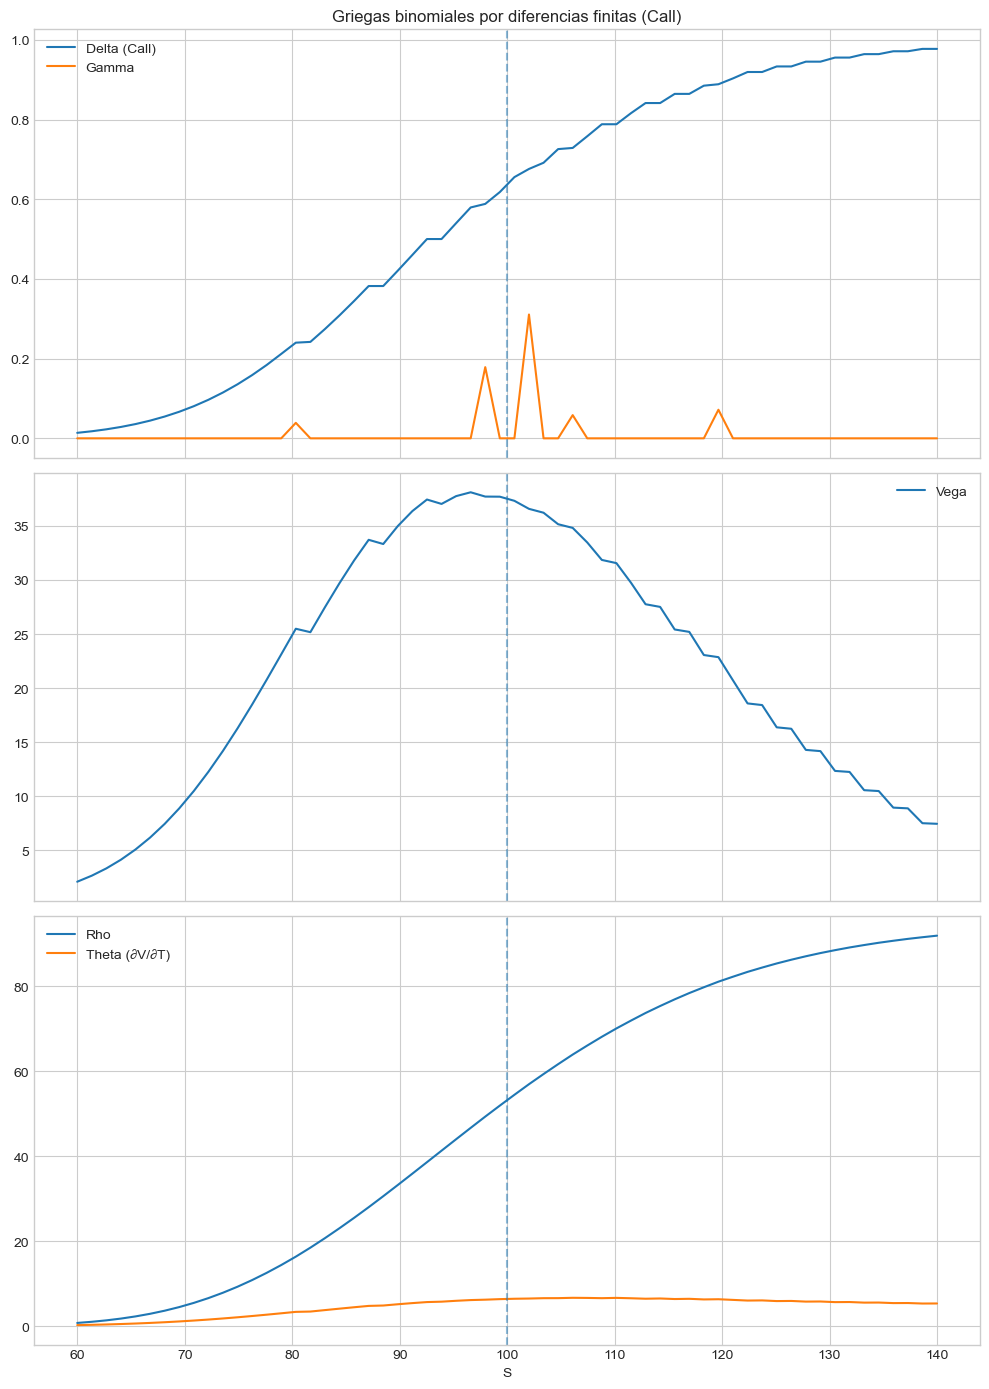

Nota: si prefieres Theta como 'time decay' positiva (pérdida por paso del tiempo), usa -Theta/365 para por día.


In [8]:
# ============================================================
# Celda 13 — Griegas por diferencias finitas usando precio CRR
# ============================================================
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

# Precio binomial CRR (europea)
def price_binomial_crr(S0, K, T, r, sigma, N=200, option_type='call'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1.0 / u
    disc = np.exp(-r * dt)
    p = (np.exp(r * dt) - d) / (u - d)
    if not (0.0 <= p <= 1.0):
        raise ValueError("Prob. riesgo-neutral fuera de [0,1]. Ajusta N o parámetros.")
    j = np.arange(N + 1)
    ST = S0 * (u**j) * (d**(N - j))
    payoff = np.maximum(ST - K, 0.0) if option_type == 'call' else np.maximum(K - ST, 0.0)
    for _ in range(N):
        payoff = disc * (p * payoff[1:] + (1 - p) * payoff[:-1])
    return payoff[0]

# Envolventes para facilitar FD en cada parámetro
def V_call(S,K,T,r,sigma,N): return price_binomial_crr(S,K,T,r,sigma,N,'call')
def V_put (S,K,T,r,sigma,N): return price_binomial_crr(S,K,T,r,sigma,N,'put')

# Diferencias finitas centrales con salvaguardas
def greek_fd(model, S, K, T, r, sigma, N=200, hS=1e-2, hσ=1e-4, hT=1e-4, hr=1e-4):
    # Delta y Gamma (respecto a S)
    Vp = model(S + hS, K, T, r, sigma, N)
    Vm = model(S - hS, K, T, r, sigma, N)
    V0 = model(S,       K, T, r, sigma, N)
    delta = (Vp - Vm) / (2*hS)
    gamma = (Vp - 2*V0 + Vm) / (hS**2)

    # Vega (respecto a sigma)
    vega = (model(S, K, T, r, sigma + hσ, N) - model(S, K, T, r, sigma - hσ, N)) / (2*hσ)

    # Rho (respecto a r)
    rho = (model(S, K, T, r + hr, sigma, N) - model(S, K, T, r - hr, sigma, N)) / (2*hr)

    # Theta (respecto a T). Por convenio la damos por año; si quieres por día, divide luego entre 365.
    # Aseguramos T - hT > 0
    T_plus  = T + hT
    T_minus = max(1e-6, T - hT)
    theta = (model(S, K, T_plus, r, sigma, N) - model(S, K, T_minus, r, sigma, N)) / (2*hT)
    # Nota: este es ∂V/∂T (suele ser negativo). Para "decadencia temporal" a veces se reporta -∂V/∂T.

    return delta, gamma, vega, rho, theta

# Parámetros de ejemplo y curvas vs S
K = 100; r = 0.05; sigma = 0.2; T = 1.0; N = 400
S_grid = np.linspace(60, 140, 60)

deltaC=[]; gammaC=[]; vegaC=[]; rhoC=[]; thetaC=[]
for S0 in S_grid:
    d,g,v,rh,th = greek_fd(V_call, S0, K, T, r, sigma, N=N, hS=0.1, hσ=1e-4, hT=1e-4, hr=1e-5)
    deltaC.append(d); gammaC.append(g); vegaC.append(v); rhoC.append(rh); thetaC.append(th)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,1, figsize=(10,14), sharex=True)
ax[0].plot(S_grid, deltaC, label='Delta (Call)')
ax[0].plot(S_grid, gammaC, label='Gamma')
ax[0].axvline(K, linestyle='--', alpha=0.5); ax[0].legend(); ax[0].grid(True)
ax[0].set_title('Griegas binomiales por diferencias finitas (Call)')

ax[1].plot(S_grid, vegaC, label='Vega')
ax[1].axvline(K, linestyle='--', alpha=0.5); ax[1].legend(); ax[1].grid(True)

ax[2].plot(S_grid, rhoC, label='Rho')
ax[2].plot(S_grid, thetaC, label='Theta (∂V/∂T)')
ax[2].axvline(K, linestyle='--', alpha=0.5); ax[2].legend(); ax[2].grid(True)
ax[2].set_xlabel('S')

plt.tight_layout(); plt.show()

print("Nota: si prefieres Theta como 'time decay' positiva (pérdida por paso del tiempo), usa -Theta/365 para por día.")


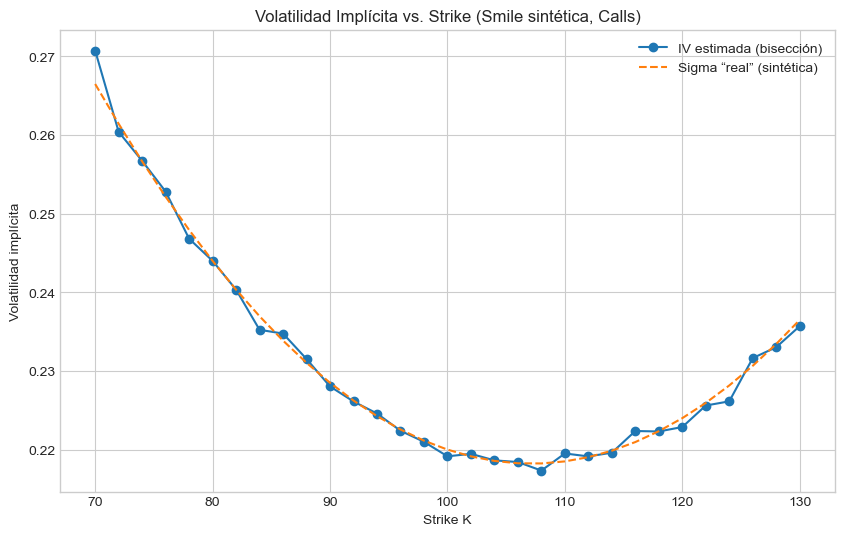

MAE IV (estimada vs. real): 0.0007


In [9]:
# ============================================================
# Celda 14 — Implied Vol (bisección) + Smile sintética
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.style.use("seaborn-v0_8-whitegrid")

def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def implied_vol_call_bisect(price, S, K, T, r, tol=1e-8, max_iter=200, sigma_low=1e-6, sigma_high=5.0):
    """IV por bisección para una Call europea (BSM). Robusto y sin derivadas."""
    f_low = bs_call(S, K, T, r, sigma_low) - price
    f_high = bs_call(S, K, T, r, sigma_high) - price
    if f_low * f_high > 0:
        # No garantiza raíz en [low, high]. Ajusta cota o revisa precio.
        return np.nan
    for _ in range(max_iter):
        mid = 0.5*(sigma_low + sigma_high)
        f_mid = bs_call(S, K, T, r, mid) - price
        if abs(f_mid) < tol or (sigma_high - sigma_low) < tol:
            return max(mid, 0.0)
        if f_low * f_mid <= 0:
            sigma_high = mid; f_high = f_mid
        else:
            sigma_low = mid;  f_low  = f_mid
    return 0.5*(sigma_low + sigma_high)

# --- Generamos “precios de mercado” sintéticos con smile ---
S0 = 100; r = 0.02; T = 0.75
# Sonrisa: sigma(K) = sigma_ATM + a*(m-1)^2 + b*(m-1), con m = K/S0
sigma_atm = 0.22; a = 0.35; b = -0.05
K_arr = np.arange(70, 131, 2)  # strikes 70..130
m = K_arr / S0
true_sigma = sigma_atm + a*(m-1.0)**2 + b*(m-1.0)
true_sigma = np.clip(true_sigma, 0.05, 1.0)

# “Precios de mercado” = BS con esa sigma + pequeño ruido (opcional)
np.random.seed(7)
market_prices = np.array([bs_call(S0, K, T, r, sig) for K, sig in zip(K_arr, true_sigma)])
# Ruido leve para parecer realistas (comenta si no lo quieres)
market_prices = np.maximum(market_prices + np.random.normal(0, 0.02, size=market_prices.size), 1e-6)

# Recuperamos IV por strike
iv_est = np.array([implied_vol_call_bisect(p, S0, K, T, r) for p, K in zip(market_prices, K_arr)])

# Plot: Smile de volatilidad implícita
plt.figure(figsize=(10,6))
plt.plot(K_arr, iv_est, marker='o', label='IV estimada (bisección)')
plt.plot(K_arr, true_sigma, linestyle='--', label='Sigma “real” (sintética)')
plt.title('Volatilidad Implícita vs. Strike (Smile sintética, Calls)')
plt.xlabel('Strike K'); plt.ylabel('Volatilidad implícita')
plt.grid(True); plt.legend()
plt.show()

# Chequeo de error agregado
mask = ~np.isnan(iv_est)
mae = np.mean(np.abs(iv_est[mask] - true_sigma[mask]))
print(f"MAE IV (estimada vs. real): {mae:.4f}")
